In [56]:
import numpy as np
import pandas as pd
from object_orient_for_JL.data_process_mat import Data_Process
from object_orient_for_JL.util import transform_date_to_age, train_model, predict_score, random_model_performance, ROC_curve_plot , DET_curve_plot

In [57]:
start_date = '2021-02-01'
train_date = '2021-05-01'
end_date = '2021-06-01'
data_process_obj = Data_Process(start_date, train_date, end_date)
data_process_obj.main()

100%|██████████| 19086/19086 [00:43<00:00, 434.72it/s]
/home/hsucheng/DCGS/tutorabc_dcgs_model/object_orient_for_JL/interest_tag_overlap_num.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_data_with_UF['overlap_num'] = overlap_num


In [58]:
label_AD = data_process_obj.label_AD
label_Jr = data_process_obj.label_Jr
ground_truth_AD = data_process_obj.ground_truth_AD
ground_truth_Jr = data_process_obj.ground_truth_Jr
train_data_AD_wo_label = data_process_obj.train_data_AD_wo_label
train_data_Jr_wo_label = data_process_obj.train_data_Jr_wo_label
test_data_AD_wo_label = data_process_obj.test_data_AD_wo_label
test_data_Jr_wo_label = data_process_obj.test_data_Jr_wo_label
train_data_AD = data_process_obj.train_data_AD
test_data_AD = data_process_obj.test_data_AD
train_data_Jr = data_process_obj.train_data_Jr
test_data_Jr = data_process_obj.test_data_Jr
mat_individual_col = data_process_obj.mat_individual_col

In [59]:
# train RF model
model_AD = train_model(train_data=train_data_AD_wo_label, label=label_AD)
model_Jr = train_model(train_data=train_data_Jr_wo_label, label=label_Jr)

In [60]:
# eval of OUR (AD)
test_data_AD_array = np.array(test_data_AD_wo_label)
y_pred_AD = model_AD.predict(test_data_AD_array)
predict_score(y_pred_AD,ground_truth_AD)

              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68     13815
         1.0       0.82      0.83      0.83     25050

    accuracy                           0.77     38865
   macro avg       0.75      0.75      0.75     38865
weighted avg       0.77      0.77      0.77     38865

---------------------------------------
Confusion Matrix
[[ 9200  4615]
 [ 4164 20886]]
---------------------------------------
positive label : 1 | negative label : 0


In [61]:
# eval of OUR (Jr)
test_data_Jr_array = np.array(test_data_Jr_wo_label)
y_pred_Jr = model_Jr.predict(test_data_Jr_array)
predict_score(y_pred_Jr,ground_truth_Jr)

              precision    recall  f1-score   support

         0.0       0.44      0.36      0.40     16221
         1.0       0.71      0.78      0.74     32990

    accuracy                           0.64     49211
   macro avg       0.58      0.57      0.57     49211
weighted avg       0.62      0.64      0.63     49211

---------------------------------------
Confusion Matrix
[[ 5876 10345]
 [ 7331 25659]]
---------------------------------------
positive label : 1 | negative label : 0


In [62]:
# data process of NCF model (AD)
client_sn_train_AD = list(train_data_AD['client_sn'])
mat_train_AD = list(train_data_AD['MaterialID'])
client_sn_test_AD = list(test_data_AD['client_sn'])
mat_test_AD = list(test_data_AD['MaterialID'])
client_sn_AD = list(set(client_sn_train_AD))
mat_AD = list(set(mat_train_AD))
uid2index_AD, mat2index_AD, uid_index,mat_index = dict(), dict(),0,0
for uid in client_sn_AD:
    uid2index_AD[uid] = uid_index
    uid_index +=1
for mat in mat_AD:
    mat2index_AD[mat] = mat_index
    mat_index +=1
client_sn_train_AD = [uid2index_AD[uid] for uid in client_sn_train_AD]
mat_train_AD = [mat2index_AD[mat] for mat in mat_train_AD]
label_train_AD = list(train_data_AD['label'])
label_test_AD = list(test_data_AD['label'])
user_num_AD = len(client_sn_AD)
item_num_AD = len(mat_AD)

In [63]:
# data process of NCF model (AD)
client_sn_train_Jr = list(train_data_Jr['client_sn'])
mat_train_Jr = list(train_data_Jr['MaterialID'])
client_sn_test_Jr = list(test_data_Jr['client_sn'])
mat_test_Jr = list(test_data_Jr['MaterialID'])
client_sn_Jr = list(set(client_sn_train_Jr))
mat_Jr = list(set(mat_train_Jr))
uid2index_Jr, mat2index_Jr, uid_index,mat_index = dict(), dict(),0,0
for uid in client_sn_Jr:
    uid2index_Jr[uid] = uid_index
    uid_index +=1
for mat in mat_Jr:
    mat2index_Jr[mat] = mat_index
    mat_index +=1
client_sn_train_Jr = [uid2index_Jr[uid] for uid in client_sn_train_Jr]
mat_train_Jr = [mat2index_Jr[mat] for mat in mat_train_Jr]
label_train_Jr = list(train_data_Jr['label'])
label_test_Jr = list(test_data_Jr['label'])
user_num_Jr = len(client_sn_Jr)
item_num_Jr = len(mat_Jr)

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from tqdm import tqdm




class NGCF(nn.Module):
    def __init__(self, n_user, n_item, norm_adj):
        super(NGCF, self).__init__()
        self.n_user = n_user
        self.n_item = n_item
        self.emb_size = 64 #(?)
        self.node_dropout = 0.1
        head_num = 3
        self.mess_dropout = [0.1 for _ in range(head_num)]
        self.norm_adj = norm_adj
        self.layers = [self.emb_size for _ in range(head_num)]
        self.decay = eval('[1e-5]')[0]
        self.embedding_dict, self.weight_dict = self.init_weight()
        self.sparse_norm_adj = self._convert_sp_mat_to_sp_tensor(self.norm_adj).cuda()
        self.predict_layer = nn.Linear((self.emb_size*4), 1).cuda()

    def init_weight(self):
        # xavier init
        initializer = nn.init.xavier_uniform_

        embedding_dict = nn.ParameterDict({
            'user_emb': nn.Parameter(initializer(torch.empty(self.n_user,
                                                 self.emb_size))),
            'item_emb': nn.Parameter(initializer(torch.empty(self.n_item,
                                                 self.emb_size)))
        })

        weight_dict = nn.ParameterDict()
        layers = [self.emb_size] + self.layers
        for k in range(len(self.layers)):
            weight_dict.update({'W_gc_%d'%k: nn.Parameter(initializer(torch.empty(layers[k],
                                                                      layers[k+1])))})
            weight_dict.update({'b_gc_%d'%k: nn.Parameter(initializer(torch.empty(1, layers[k+1])))})

            weight_dict.update({'W_bi_%d'%k: nn.Parameter(initializer(torch.empty(layers[k],
                                                                      layers[k+1])))})
            weight_dict.update({'b_bi_%d'%k: nn.Parameter(initializer(torch.empty(1, layers[k+1])))})

        return embedding_dict, weight_dict

    def _convert_sp_mat_to_sp_tensor(self, X):
        coo = X.tocoo()
        i = torch.LongTensor([coo.row, coo.col])
        v = torch.from_numpy(coo.data).float()
        return torch.sparse.FloatTensor(i, v, coo.shape)

    def sparse_dropout(self, x, rate, noise_shape):
        random_tensor = 1 - rate
        random_tensor += torch.rand(noise_shape).to(x.device)
        dropout_mask = torch.floor(random_tensor).type(torch.bool)
        i = x._indices()
        v = x._values()
        i = i[:, dropout_mask]
        v = v[dropout_mask]
        out = torch.sparse.FloatTensor(i, v, x.shape).to(x.device)
        return out * (1. / (1 - rate))

    def rating(self, u_g_embeddings, pos_i_g_embeddings):
        return torch.matmul(u_g_embeddings, pos_i_g_embeddings.t())

    def forward(self, users, items, drop_flag=True):
        A_hat = self.sparse_dropout(self.sparse_norm_adj,
                                    self.node_dropout,
                                    self.sparse_norm_adj._nnz()) if drop_flag else self.sparse_norm_adj
        ego_embeddings = torch.cat([self.embedding_dict['user_emb'],
                                    self.embedding_dict['item_emb']], 0)
        all_embeddings = [ego_embeddings]
        for k in range(len(self.layers)):
            side_embeddings = torch.sparse.mm(A_hat, ego_embeddings)
            # transformed sum messages of neighbors.
            sum_embeddings = torch.matmul(side_embeddings, self.weight_dict['W_gc_%d' % k]) \
                                             + self.weight_dict['b_gc_%d' % k]
            # bi messages of neighbors.
            # element-wise product
            bi_embeddings = torch.mul(ego_embeddings, side_embeddings)
            # transformed bi messages of neighbors.
            bi_embeddings = torch.matmul(bi_embeddings, self.weight_dict['W_bi_%d' % k]) \
                                            + self.weight_dict['b_bi_%d' % k]
            # non-linear activation.
            ego_embeddings = nn.LeakyReLU(negative_slope=0.2)(sum_embeddings + bi_embeddings)
            # message dropout.
            ego_embeddings = nn.Dropout(self.mess_dropout[k])(ego_embeddings)
            # normalize the distribution of embeddings.
            norm_embeddings = F.normalize(ego_embeddings, p=2, dim=1)
            all_embeddings += [norm_embeddings]
        #look up
        all_embeddings = torch.cat(all_embeddings, 1)
        u_g_embeddings = all_embeddings[:self.n_user, :]
        i_g_embeddings = all_embeddings[self.n_user:, :]  
        u_g_embeddings = u_g_embeddings[users, :]
        i_g_embeddings = i_g_embeddings[items, :]
        # interaction
        pair_emb = u_g_embeddings * i_g_embeddings
        prediction = self.predict_layer(pair_emb)
        return torch.sigmoid(prediction.view(-1))

class NGCF_Modeling:
    def __init__(self, n_user, n_item, norm_adj):
        lr = 0.001
        self.epochs = 20
        self.batch_size = 1024
        # model
        self.model = NGCF(n_user, n_item, norm_adj).cuda()
        # build loss func and opt
        self.loss_function = nn.BCEWithLogitsLoss() 
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    
    def train(self, train_user, train_item, train_label):
        print('Start to train NCF model!!')
        batch_num = int(len(train_label) / self.batch_size) + 1
        for epoch in tqdm(range(self.epochs)):
            self.model.train()
            for i in range(batch_num):
                user = train_user[i*self.batch_size : (i+1)*self.batch_size]
                item = train_item[i*self.batch_size : (i+1)*self.batch_size]
                label = torch.tensor(train_label[i*self.batch_size : (i+1)*self.batch_size]).float().cuda()
                self.model.zero_grad()
                prediction = self.model(user, item)  # shape=(256,) | Real number
                loss = self.loss_function(prediction, label)
                loss.backward()
                self.optimizer.step()
        print('Finish training model!!')  

      
    def recommend(self, user, item, uid2index ,mat2index, rf_model, test_data):
        non_cold_start_user, non_cold_start_item, non_cold_start_index = list(), list(), list()
        cold_start_user, cold_start_item, cold_start_index = list(), list(), list()
        for i in range(len(user)):
            if user[i] in uid2index and item[i] in mat2index:
                non_cold_start_user.append(uid2index[user[i]])
                non_cold_start_item.append(mat2index[item[i]])
                non_cold_start_index.append(i)
            else:
                cold_start_user.append(user[i])
                cold_start_item.append(item[i])  
                cold_start_index.append(i)
        # non_cold_start part 
        non_cold_start_pred = list(self.model(non_cold_start_user, non_cold_start_item).cpu().detach().numpy())
        # cold_start part
        cold_start_pred = list()
        for i in range(len(cold_start_user)):
            dat = test_data[(test_data['client_sn']==cold_start_user[i]) & (test_data['MaterialID']==cold_start_item[i])]
            dat = np.array(dat)
            predictions = rf_model.predict(dat)
            predictions = predictions[0]   
            cold_start_pred.append(predictions)
        # intergrate
        predictions_list = list()
        for i in range(len(non_cold_start_pred)):
            predictions_list.append([non_cold_start_pred[i], non_cold_start_index[i]])
        for i in range(len(cold_start_pred)):
            predictions_list.append([cold_start_pred[i], cold_start_index[i]])
        predictions_list = sorted(predictions_list, key=lambda x:x[1])
        predictions_list = [element[0] for element in predictions_list]
        predictions = np.array(predictions_list)
        del self.model
        return predictions 

In [65]:
from object_orient_for_JL.adj_matx_generator import Adj_Matx_Generator
amg_obj = Adj_Matx_Generator(user_num_AD, item_num_AD, [client_sn_train_AD, mat_train_AD])
onehot_adj,norm_adj,normalized_adj = amg_obj.main()
norm_adj = normalized_adj

In [66]:
# train NCF model (AD)
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
ngcf_obj = NGCF_Modeling(user_num_AD, item_num_AD,norm_adj)
ngcf_obj.train(client_sn_train_AD, mat_train_AD, label_train_AD)

  0%|          | 0/20 [00:00<?, ?it/s]

Start to train NCF model!!


100%|██████████| 20/20 [00:31<00:00,  1.59s/it]

Finish training model!!


In [67]:
# eval (AD)
y_pred_AD = ngcf_obj.recommend(client_sn_test_AD, mat_test_AD,uid2index_AD ,mat2index_AD, model_AD, test_data_AD_wo_label)
ground_truth_AD = np.array(label_test_AD)

In [68]:
predict_score(y_pred_AD,ground_truth_AD,0.5)

              precision    recall  f1-score   support

         0.0       0.62      0.75      0.68     13815
         1.0       0.84      0.75      0.79     25050

    accuracy                           0.75     38865
   macro avg       0.73      0.75      0.74     38865
weighted avg       0.76      0.75      0.75     38865

---------------------------------------
Confusion Matrix
[[10347  3468]
 [ 6301 18749]]
---------------------------------------
positive label : 1 | negative label : 0


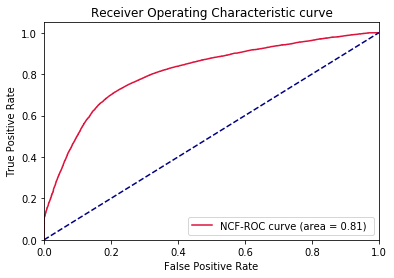

In [69]:
y_with_pred_list = [(ground_truth_AD, y_pred_AD)]
model_name_list = ['NCF']
model_color_list = ['crimson']
ROC_curve_plot(y_with_pred_list, model_name_list, model_color_list)

In [70]:
# 0.81/0.74/0.77/0.73 (AD)
# 0.81/0.75/0.78/0.73 (AD)
# 0.82/0.73/0.77/0.73 (AD)
# 0.80/0.75/0.78/0.73
# modeling : epoch : 10,20,30,40

In [71]:
from object_orient_for_JL.adj_matx_generator import Adj_Matx_Generator
amg_obj = Adj_Matx_Generator(user_num_Jr, item_num_Jr, [client_sn_train_Jr, mat_train_Jr])
onehot_adj,norm_adj,normalized_adj = amg_obj.main()
norm_adj = normalized_adj

In [72]:
# train NCF model (Jr)
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
ngcf_obj = NGCF_Modeling(user_num_Jr, item_num_Jr,norm_adj)
ngcf_obj.train(client_sn_train_Jr, mat_train_Jr, label_train_Jr)

  0%|          | 0/20 [00:00<?, ?it/s]

Start to train NCF model!!


100%|██████████| 20/20 [00:42<00:00,  2.11s/it]

Finish training model!!


In [73]:
# eval (Jr)
y_pred_Jr = ngcf_obj.recommend(client_sn_test_Jr, mat_test_Jr,uid2index_Jr ,mat2index_Jr, model_Jr, test_data_Jr_wo_label)
ground_truth_Jr = np.array(label_test_Jr)

In [74]:
predict_score(y_pred_Jr,ground_truth_Jr,0.5)

              precision    recall  f1-score   support

         0.0       0.59      0.68      0.63     16221
         1.0       0.83      0.77      0.80     32990

    accuracy                           0.74     49211
   macro avg       0.71      0.72      0.71     49211
weighted avg       0.75      0.74      0.74     49211

---------------------------------------
Confusion Matrix
[[10963  5258]
 [ 7680 25310]]
---------------------------------------
positive label : 1 | negative label : 0


In [75]:
# 0.81/0.75/0.78/0.72 (Jr)
# 0.83/0.75/0.79/0.73
# 0.82/0.75/0.79/0.73
# 0.81/0.77/0.79/0.73
# modeling : epoch : 10,20,30,40

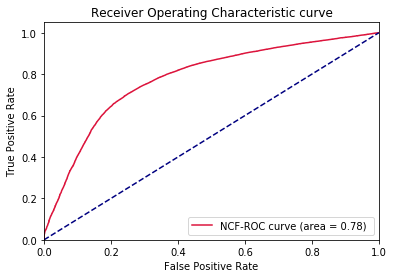

In [76]:
y_with_pred_list = [(ground_truth_Jr, y_pred_Jr)]
model_name_list = ['NCF']
model_color_list = ['crimson']
ROC_curve_plot(y_with_pred_list, model_name_list, model_color_list)